# NYC_Taxi EDA

### Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration for nicer plots
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# FILE PATH - Update this to match your actual CSV name
# We go up one level (../) from 'notebooks/' to find 'data/'
RAW_DATA_PATH = '../data/raw/taxi_data.csv' 

print("Setup Complete. Ready to load data.")

Setup Complete. Ready to load data.


### Efficient Data Loading

In [2]:
# Load only the first 500k rows
print(f"Loading sample from {RAW_DATA_PATH}...")

try:
    df = pd.read_csv(RAW_DATA_PATH, nrows=500000)
    
    # Convert timestamps immediately to save memory and enable time math
    if 'tpep_pickup_datetime' in df.columns:
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        
    print(f"✅ Success! Loaded {len(df)} rows.")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("Error: File not found. Please check RAW_DATA_PATH in Cell 1.")

Loading sample from ../data/raw/taxi_data.csv...


C:\Users\torre\AppData\Local\Temp\ipykernel_11764\2769670423.py:5: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATA_PATH, nrows=500000)
C:\Users\torre\AppData\Local\Temp\ipykernel_11764\2769670423.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
C:\Users\torre\AppData\Local\Temp\ipykernel_11764\2769670423.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])


✅ Success! Loaded 500000 rows.
Memory Usage: 120.98 MB


### General Health Check

In [3]:
# 1. Peek at the data
display(df.head())

# 2. Check types and missing values
print("\n--- Info & Missing Values ---")
df.info()

# 3. Check for duplicates in this sample
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2,3.800,1,N,142,236,1,14.500,3.000,0.500,3.650,0.000,0.300,21.950,2.500,0.000
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1,2.100,1,N,236,42,1,8.000,0.500,0.500,4.000,0.000,0.300,13.300,0.000,0.000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1,0.970,1,N,166,166,1,7.500,0.500,0.500,1.760,0.000,0.300,10.560,0.000,0.000
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1,1.090,1,N,114,68,2,8.000,0.500,0.500,0.000,0.000,0.300,11.800,2.500,0.000
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1,4.300,1,N,68,163,1,23.500,0.500,0.500,3.000,0.000,0.300,30.300,2.500,0.000



--- Info & Missing Values ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               500000 non-null  int64         
 1   tpep_pickup_datetime   500000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  500000 non-null  datetime64[ns]
 3   passenger_count        500000 non-null  int64         
 4   trip_distance          500000 non-null  float64       
 5   RatecodeID             500000 non-null  int64         
 6   store_and_fwd_flag     500000 non-null  object        
 7   PULocationID           500000 non-null  int64         
 8   DOLocationID           500000 non-null  int64         
 9   payment_type           500000 non-null  int64         
 10  fare_amount            500000 non-null  object        
 11  extra                  500000 non-null  float64       
 12  mta_tax      

### Target Variable Analysis (fare_amount)

Rows with invalid non-numeric fares converted to NaN: 1

--- Fare Amount Statistics ---
count   499999.000
mean        13.465
std         13.918
min       -480.000
25%          6.500
50%          9.000
75%         14.000
max        668.000
Name: fare_amount, dtype: float64

Negative Fares: 2829 (0.5658%)
Zero Fares: 256 (0.0512%)


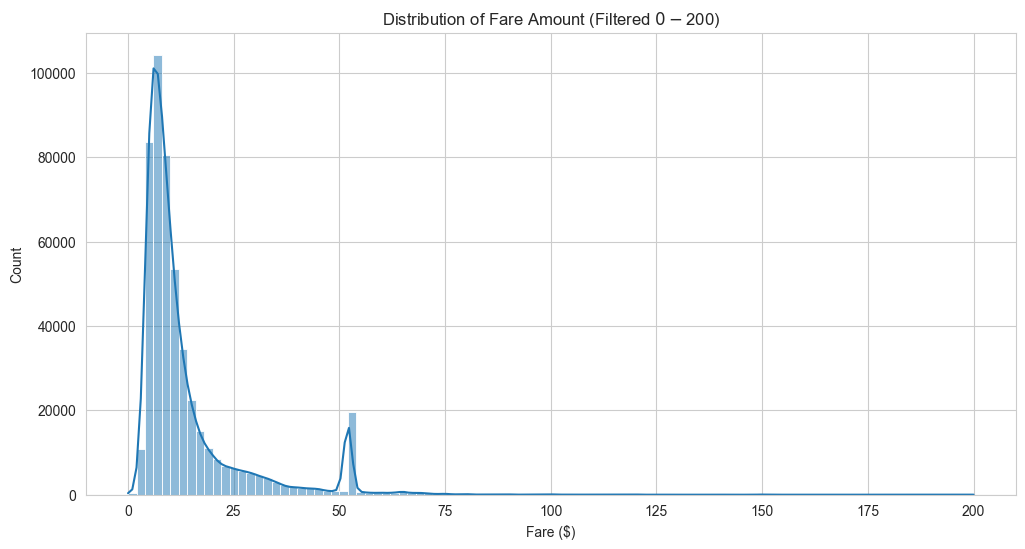

In [5]:
# 'coerce' turns invalid strings (like 'Unknown' or '$10') into NaN
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')

# Check if we lost any data during conversion
invalid_rows = df['fare_amount'].isna().sum()
print(f"Rows with invalid non-numeric fares converted to NaN: {invalid_rows}")

# Drop rows where fare_amount is NaN (if any) to keep analysis clean
df = df.dropna(subset=['fare_amount'])

# --- NOW RUN THE ORIGINAL ANALYSIS ---
print("\n--- Fare Amount Statistics ---")
print(df['fare_amount'].describe())

# Check for Negative Fares (Refunds/Errors)
neg_fares = df[df['fare_amount'] < 0]
zero_fares = df[df['fare_amount'] == 0]

print(f"\nNegative Fares: {len(neg_fares)} ({len(neg_fares)/len(df)*100:.4f}%)")
print(f"Zero Fares: {len(zero_fares)} ({len(zero_fares)/len(df)*100:.4f}%)")

# Visualization (Filter out extreme outliers > $200 for readability)
plt.figure(figsize=(12, 6))
sns.histplot(df[df['fare_amount'].between(0, 200)]['fare_amount'], bins=100, kde=True)
plt.title('Distribution of Fare Amount (Filtered $0-$200)')
plt.xlabel('Fare ($)')
plt.show()

### Feature Engineering

In [6]:
# 1. Calculate Trip Duration (in minutes)
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# 2. Inspect Duration Anomalies
print("--- Trip Duration Statistics (Minutes) ---")
print(df['trip_duration_min'].describe())

# Check for negative duration (Dropoff before Pickup?)
neg_duration = df[df['trip_duration_min'] < 0]
print(f"\nNegative Durations: {len(neg_duration)}")

# Check for absurdly long trips (> 5 hours)
long_trips = df[df['trip_duration_min'] > 300]
print(f"Trips > 5 Hours: {len(long_trips)}")

--- Trip Duration Statistics (Minutes) ---
count   499999.000
mean        13.963
std         50.506
min          0.000
25%          5.983
50%          9.667
75%         15.617
max       8513.183
Name: trip_duration_min, dtype: float64

Negative Durations: 0
Trips > 5 Hours: 658


### Categorical and Logical Checks

--- Passenger Count Distribution ---
passenger_count
0     10715
1    364826
2     77021
3     20120
4      9349
5     11366
6      6600
7         1
8         1
Name: count, dtype: int64

Trips with 0 distance but valid fare: 6261


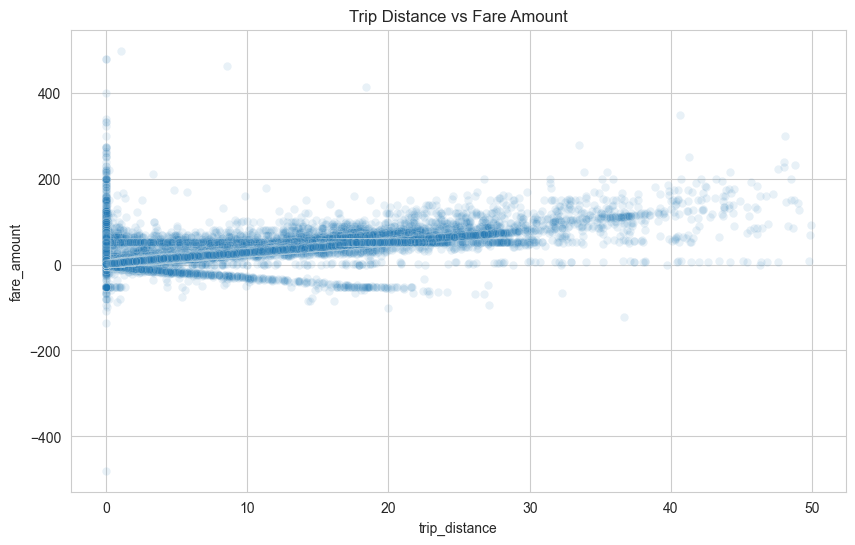

In [7]:
# 1. Passenger Count
print("--- Passenger Count Distribution ---")
print(df['passenger_count'].value_counts().sort_index())

# 2. Trip Distance vs Fare
# Are there trips with 0 distance but > $0 fare?
zero_dist_paid = df[(df['trip_distance'] == 0) & (df['fare_amount'] > 0)]
print(f"\nTrips with 0 distance but valid fare: {len(zero_dist_paid)}")

# Visualization: Distance vs Fare
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['trip_distance'] < 50], x='trip_distance', y='fare_amount', alpha=0.1)
plt.title('Trip Distance vs Fare Amount')
plt.show()